In [57]:
# Core jax
import jax
# from jax.config import config
jax.config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from dLuxToliman import ApplyBasisCLIMB, TolimanOpticalSystem

# gonna have to define my own log likelihoods which are analytic contiuations???

from jax.scipy.special import gammaln, xlogy

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

plt.rcParams["image.origin"] = 'lower'

from pathlib import Path

In [58]:
# Marginal params
marginal_params = 'position'

# Loss function, optimising the zernikes
opt_param = 'aperture.coefficients'
@zdx.filter_jit
@zdx.filter_value_and_grad(opt_param)

def fim_loss_func(optics, sources, detector, parameters):
    covs = []
    for source in sources:
        model = dl.Telescope(optics, source, detector)
        data = model.model()
        cov = zdx.covariance_matrix(model, parameters, poiss_loglike, data=data)
        covs.append(cov)

    # convert list -> array: shape (n_sources, n_params, n_params)
    covs_arr = np.stack(covs)   # or np.asarray(covs)

    # trace over the last two axes to get one trace per source
    traces = np.trace(covs_arr, axis1=-2, axis2=-1)   # shape (n_sources,)

    # average of the top-k traces (k=10)
    k = 4
    traces_sorted = np.sort(traces)   # ascending
    topk = traces_sorted[-k:]         # if n_sources < k this returns all traces
    avg_topk = np.mean(topk)


    # log it
    loss = np.log10(avg_topk)

    return loss

In [59]:
n_sources = 20
key = jr.PRNGKey(2)

positions = jr.uniform(key, (n_sources,2))

print(positions)
wf_npix = 256 
diameter = 0.125 # This is default of toliman optical system. Can change.

### Can apply these to the input if you just want a clear aperture
m2_diameter = 0
strut_width = 0
###

wavelength = 585e-9

# This is to what degree we undersample Nyquist
nyquist_factor = 16
psf_npix = 256 / nyquist_factor
psf_pixel_scale = nyquist_factor * dlu.rad2arcsec(wavelength/(2*diameter))
oversample = nyquist_factor * 4 # sample at 4x nyquist originally

# Place the source in the centre of the top right from center pixel.
# That's what the position argument does here
sources = []
for i in np.arange(n_sources):
    position = positions[i]
    source = dl.PointSource(flux=1e6,position=dlu.arcsec2rad(psf_pixel_scale*position),wavelengths=np.array([wavelength]))
    sources.append(source)

climb_basis = np.load("../xk5/bases/basis4.npy")

coefficients = (0)*jr.normal(key, [len(climb_basis)])
mean_wl = source.wavelengths.mean()

# have to make sure that mean_wl is in meters.
mask_layer = ApplyBasisCLIMB(climb_basis, mean_wl, coefficients)

# Construct instrument
optics = TolimanOpticalSystem(wf_npixels=wf_npix,psf_npixels=psf_npix, mask=mask_layer,
                            radial_orders=[2, 3], psf_pixel_scale=psf_pixel_scale, oversample=oversample)

# detector layer
detector_layers = [
    (
        'downsample',
        dl.detector_layers.Downsample(oversample)
    )
]

detector = dl.LayeredDetector(layers = detector_layers)

[[0.23155022 0.41192464]
 [0.32713692 0.9724925 ]
 [0.23640781 0.1860996 ]
 [0.2734274  0.07668933]
 [0.43389623 0.67350879]
 [0.50305049 0.78595013]
 [0.74931857 0.43223509]
 [0.07193898 0.84318793]
 [0.72154967 0.61953272]
 [0.82628604 0.07712804]
 [0.20792683 0.73958699]
 [0.87850711 0.75410145]
 [0.09988019 0.58996445]
 [0.55809427 0.6840143 ]
 [0.62957207 0.52834261]
 [0.52864436 0.22801133]
 [0.59957541 0.29188102]
 [0.19986785 0.80789296]
 [0.66234417 0.91709635]
 [0.18329504 0.91384041]]


In [60]:
#fim_loss_func(optics, sources, detector, marginal_params)

optim, opt_state = zdx.get_optimiser(optics, opt_param, optax.adam(1e-9))

losses, models_out = [], [optics]
with tqdm(range(200), desc='Gradient Descent') as t:
    for i in t:
        loss, grads = fim_loss_func(optics, sources, detector, marginal_params)
        updates, opt_state = optim.update(grads, opt_state)   # your zdx API
        optics = zdx.apply_updates(optics, updates)
        models_out.append(optics)
        losses.append(loss)
        t.set_description("Loss: {:.6f}".format(float(loss)))

Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

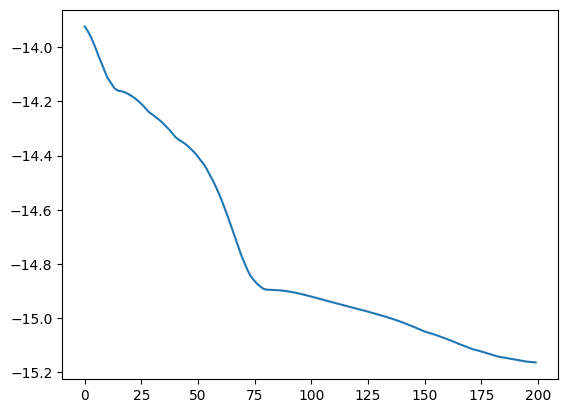

In [61]:
plt.plot(losses)
plt.show()

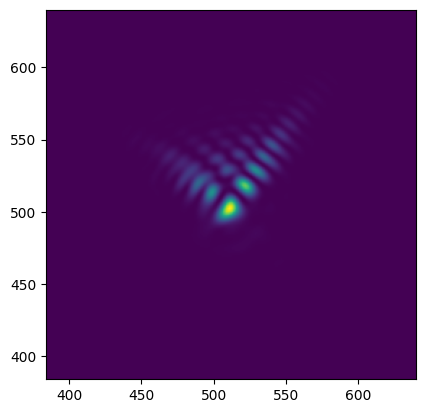

In [64]:
plt.imshow(dlu.downsample(models_out[-1].propagate_mono(585e-9),1,False))
plt.xlim(512-128,512+128)
plt.ylim(512-128,512+128)
plt.show()

In [65]:
models_out[-1].aperture.coefficients

Array([-3.48254124e-08,  1.15821132e-07, -1.55107111e-08, -1.14975998e-07,
       -1.45075177e-08, -6.08195016e-08,  6.39075163e-08], dtype=float64)